# Final Project

## Import Data
Using pandas, we can import the dataset into df_credit

In [40]:
import pandas as pd

# Dataset was downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud
df_credit = pd.read_csv("../data/creditcard.csv")

To ensure randomness, the data will be shuffled

In [41]:
df_credit = df_credit.sample(frac=1)

In [42]:
 save_figures = True
if save_figures:
    import os
    if not os.path.exists('pics'):
        os.makedirs('pics')


## Data Analysis

First, we need to know if there are any missing values to address. From glancing at the raw data, there doesn't seem to be any missing data or values that represent missing values.

In [4]:
print('Number of missing (null) values in the dataframe: ', df_credit.isnull().sum().sum())

Number of missing (null) values in the dataframe:  0


Because there are no missing values, we will continue analyzing the data by checking if the data is encoded properly. We do this by checking the features data type.

In [5]:
print(df_credit.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


The data is encoded properly, so no changes will be made. We can now proceed to further analyze the data by observing the distribution of classes.

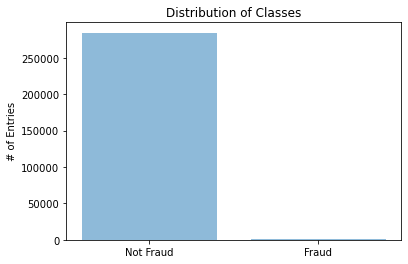

amount of class 0 (no fraud):  284315
amount of class 1 (fraud):  492
0.173 % of the data are fraudulent credit charges


In [6]:
import numpy as np
import matplotlib.pyplot as plt

num_of_nofraud = df_credit['Class'].value_counts()[0]
num_of_fraud = df_credit['Class'].value_counts()[1]

classes = ('Not Fraud', 'Fraud')
y_pos = np.arange(len(classes))
performance = [num_of_nofraud, num_of_fraud]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('# of Entries')
plt.title('Distribution of Classes')

plt.show()

print('amount of class 0 (no fraud): ', num_of_nofraud)
print('amount of class 1 (fraud): ', num_of_fraud)

print(round(num_of_fraud/len(df_credit) * 100, 3), '% of the data are fraudulent credit charges')

The data has a clear imbalance and will hurt our model with high variance. This leads to a model that overfits the data.

Next, we can display statistical data on the only two features that have not been already transformed and provide us with a descriptive title: "Time" and "Amount". 

In [7]:
fraud = df_credit[df_credit['Class'] == 1]
nonfraud = df_credit[df_credit['Class'] == 0]

## How the amount spent relates to fraudulent charges
print(pd.concat([fraud.Amount.describe(), nonfraud.Amount.describe()], axis=1))

## How the time frame between purchases relates to fraudulent charges
print(pd.concat([fraud.Time.describe(), nonfraud.Time.describe()], axis=1))

            Amount         Amount
count   492.000000  284315.000000
mean    122.211321      88.291022
std     256.683288     250.105092
min       0.000000       0.000000
25%       1.000000       5.650000
50%       9.250000      22.000000
75%     105.890000      77.050000
max    2125.870000   25691.160000
                Time           Time
count     492.000000  284315.000000
mean    80746.806911   94838.202258
std     47835.365138   47484.015786
min       406.000000       0.000000
25%     41241.500000   54230.000000
50%     75568.500000   84711.000000
75%    128483.000000  139333.000000
max    170348.000000  172792.000000


These values do give us some insight as to how fraudulent charges can be identified from these two features alone, but is clearly not going to work on their own.

Another interesting characteristic of these feature columns is that they are the only columns to not have gone through PCA transformation. This can be seen by their distribution of data.

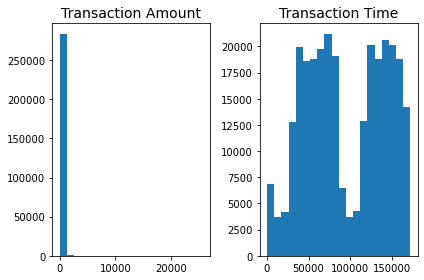

In [8]:
## lets see what amount and time look like
amount_val = df_credit['Amount'].values
time_val = df_credit['Time'].values
n_bins = 20

fig, axs = plt.subplots(1, 2, tight_layout=True)

# a histogram will be used to see the general distribution
# of values through a histogram.
axs[0].set_title('Transaction Amount', fontsize=14)
axs[0].hist(amount_val, bins=n_bins)

axs[1].set_title('Transaction Time', fontsize=14)
axs[1].hist(time_val, bins=n_bins)

plt.show()

The plotted distribution of the data shows us just how skewed the data is. There are outliers that could hurt the classification ability of our model. There is also an extremely large range in values as compared to the other features, as seen below.

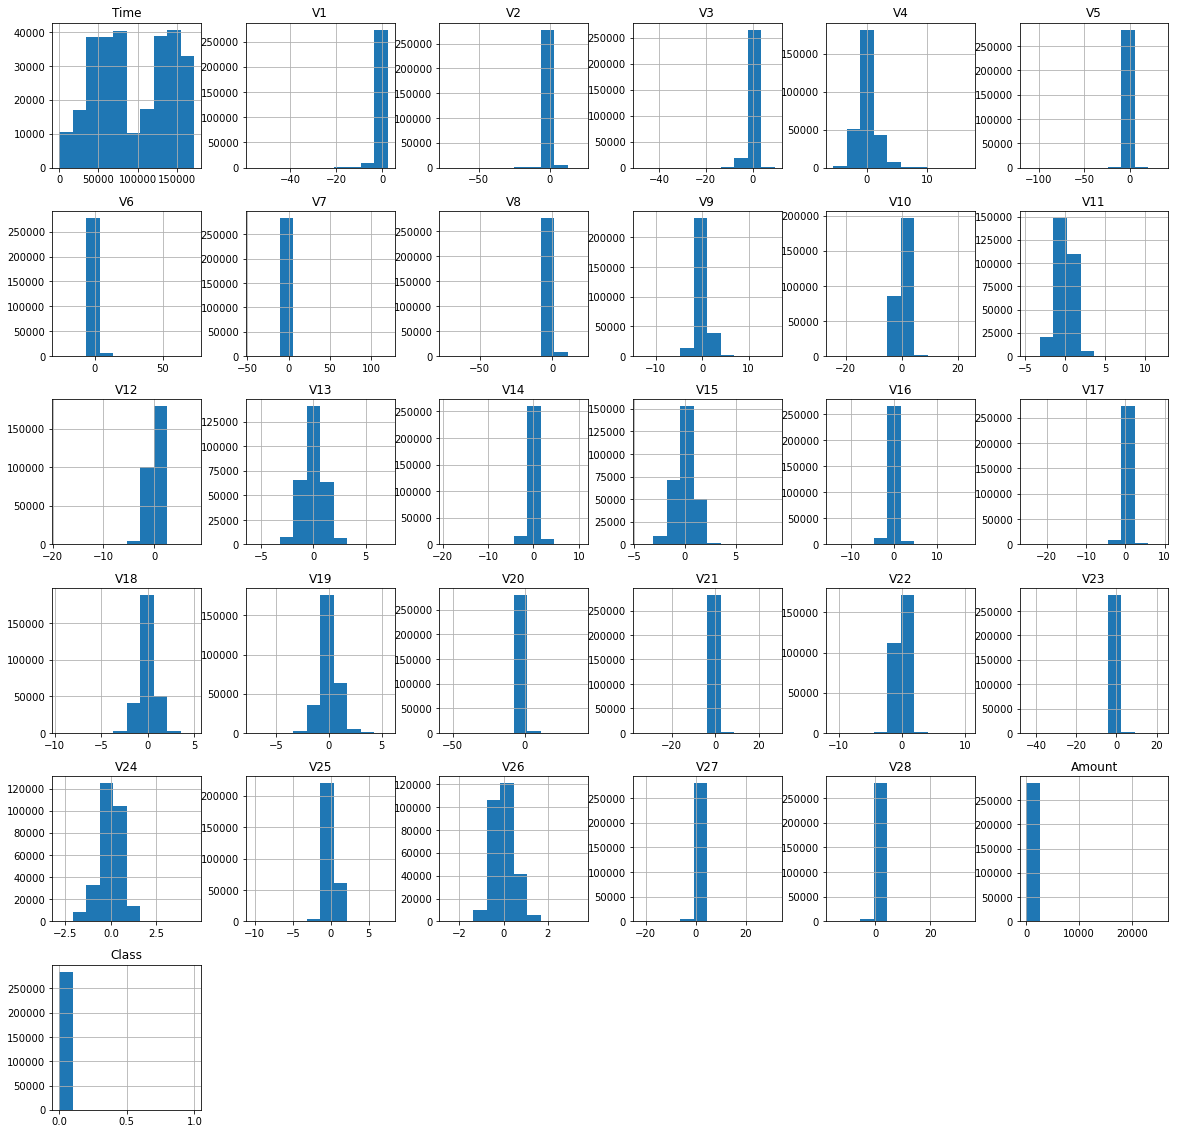

In [9]:
df_credit.hist(figsize=(20, 20));

## Data Preprocessing

To fix the class imbalance present in our dataframe, we decided to split our data so that the class distribution is exactly 50/50.

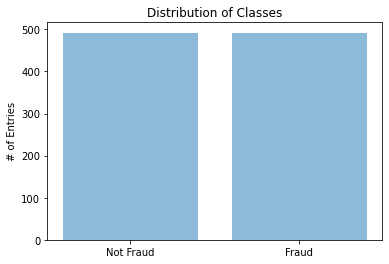

amount of class 0 (no fraud):  492
amount of class 1 (fraud):  492


In [10]:
df_fraud = df_credit.loc[df_credit['Class'] == 1]

# We know that there are 492 fraud entries, so we should limit the
# number of non fraudulent entries to 492 to keep it even.
df_nonfraud = df_credit.loc[df_credit['Class'] == 0][:len(df_fraud.index)]

# we combine the data frames we created into one evenly
# distributed dataframe.
df_credit_new = pd.concat([df_fraud, df_nonfraud])

# Shuffle
df_credit_new = df_credit_new.sample(frac=1)

num_of_nofraud = df_credit_new['Class'].value_counts()[0]
num_of_fraud = df_credit_new['Class'].value_counts()[1]

# Illustrate the new class count
classes = ('Not Fraud', 'Fraud')
y_pos = np.arange(len(classes))
performance = [num_of_nofraud, num_of_fraud]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('# of Entries')
plt.title('Distribution of Classes')

plt.show()

print('amount of class 0 (no fraud): ', num_of_nofraud)
print('amount of class 1 (fraud): ', num_of_fraud)

Now, the class distribution is even and the size of the dataset is cut down which makes future functions a lot easier and faster to process.

The next step to making the data reliable is to perform some transformation on the "Time" and "Amount" feature columns. We decided to perform standard scaling.

Before StandardScaler fitting and transformation: 
             Time        V1        V2        V3        V4        V5        V6  \
79835    58199.0  0.340391  2.015233 -2.777330  3.812024 -0.461729 -1.152022   
178208  123525.0 -5.904921  4.439911 -8.631802  7.788684 -4.989580 -1.200144   
27797    34706.0 -0.017906 -1.359827 -0.038806  3.012939 -0.715069 -0.138055   
274382  165981.0 -5.766879 -8.402154  0.056543  6.950983  9.880564 -5.773192   
8617     11635.0  0.919137  4.199633 -7.535607  7.426940  1.118215 -2.886722   

              V7        V8        V9  ...       V21       V22       V23  \
79835  -2.001959  0.548681 -2.344042  ...  0.299769 -0.583283 -0.187696   
178208 -7.674060  4.125761 -5.315778  ...  1.775030  1.266441 -0.199410   
27797   0.912350 -0.165709 -0.802827  ...  0.412086 -0.188151 -0.505350   
274382 -5.748879  0.721743 -1.076274  ...  0.880395 -0.130436  2.241471   
8617   -1.341036  0.363933 -2.203224  ...  0.316094  0.055179  0.210692   

             V24

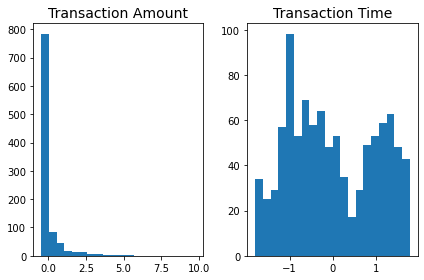

In [11]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

## Before the standard scaler fitting and transformation
print("Before StandardScaler fitting and transformation: \n", df_credit_new.head())

## Time and Amount will be transformed with StandardScaler
df_credit_new = df_credit_new.assign(Time=sc.fit_transform(df_credit_new['Time'].values.reshape(-1, 1)),
                             Amount=sc.fit_transform(df_credit_new['Amount'].values.reshape(-1, 1)))

## See what the new transformed columns look like
print("After StandardScaler fitting and transformation: \n", df_credit_new.head())

In [ ]:
# Create a histogram with these new values
amount_val = df_credit_new['Amount'].values
time_val = df_credit_new['Time'].values

n_bins = 20

fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].set_title('Transaction Amount', fontsize=14)
axs[0].hist(amount_val, bins=n_bins)

axs[1].set_title('Transaction Time', fontsize=14)
axs[1].hist(time_val, bins=n_bins)

plt.show()

The last thing to do before moving on to Feature Selection is to seperate the data between training and testing data.

In [12]:
from sklearn.model_selection import train_test_split

X, y = df_credit_new.iloc[:, :-1].values, df_credit_new.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1, stratify = y)

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Feature Selection

Our team decided to use sequential backwards selection, SBS, to identify feature importance.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.2, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## Feature Importances

 1) V15                            0.185803
 2) V11                            0.119170
 3) V13                            0.092854
 4) V5                             0.089338
 5) V12                            0.089176
 6) V18                            0.083107
 7) V4                             0.049948
 8) V8                             0.040438
 9) V17                            0.035731
10) V3                             0.025001
11) V22                            0.018429
12) V19                            0.013955
13) V10                            0.013938
14) V20                            0.013170
15) Class                          0.012187
16) V21                            0.011832
17) V6                             0.010151
18) V2                             0.010026
19) V28                            0.009976
20) V9                             0.009108
21) V7                             0.009045
22) V24                            0.008244
23) V14                         

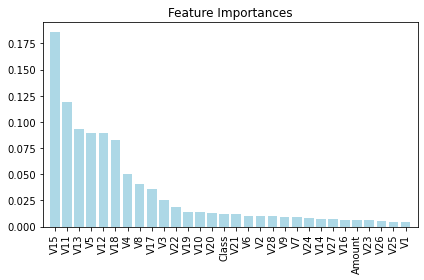

In [14]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_credit.columns[1:]
forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train,y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color='lightblue',
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

We will be performing SBS on three different models: Logistic Regression, Support Vector Machine, and Random Forest.

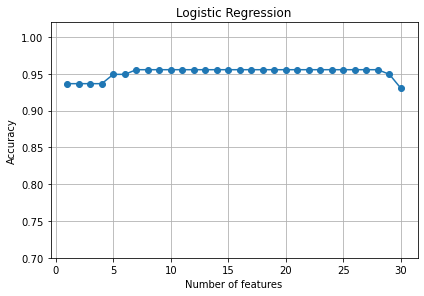

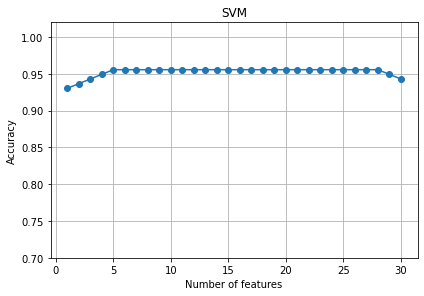

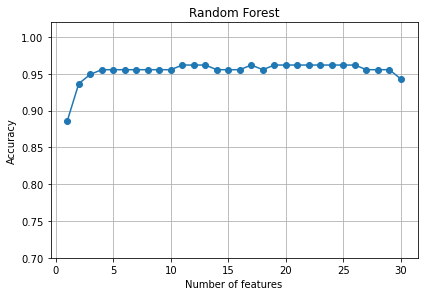

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Declare the learning algorithms that will be used
lreg = LogisticRegression(max_iter=10000,solver='lbfgs')
svm = SVC(gamma='scale')
rf = RandomForestClassifier(n_estimators=100)

### selecting features
## Logistic Regression
sbs = SBS(lreg, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("Logistic Regression")
plt.show()

## SVM
sbs = SBS(svm, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("SVM")
plt.show()

## Random Forest
sbs = SBS(rf, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("Random Forest")
plt.show()


## Hyper-Parameter Tuning

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Setup pipes

pipe_lr = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=1, max_iter=10000))
pipe_svm = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestClassifier())

# Grid search feature extraction

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# Grid Search on lr
param_grid = [{'logisticregression__C': param_range, 
               'logisticregression__solver': ['lbfgs'],
               'logisticregression__penalty':['l2']},
              {'logisticregression__C': param_range,
               'logisticregression__solver': ['liblinear'],
               'logisticregression__penalty':['l1','l2']},
              {'logisticregression__C': param_range,
               'logisticregression__solver': ['sag'],
               'logisticregression__penalty':['l2']}]

gs = GridSearchCV(pipe_lr, 
                  param_grid,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_LR = gs.best_params_
print('Grid Search best score (LR): %f' % gs.best_score_)
print('Grid Search best params(LR): ', best_params_LR)

# Grid Search on svm
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear'],
              'svc__gamma': param_range},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(pipe_svm, 
                  param_grid, 
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_SVM =gs.best_params_
print('Grid Search best score (SVM): %f' % gs.best_score_)
print('Grid Search best params (SVM): ', best_params_SVM)

# Grid Search on rf
param_grid = [{'randomforestclassifier__n_estimators': [100, 120, 140, 160, 180, 200], 
               'randomforestclassifier__max_depth': [5, 10, 20, 30, None],
               'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 1}, {0: 1, 1: 5}]}]

gs = GridSearchCV(pipe_rf,
                  param_grid,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_RF = gs.best_params_
print('Grid Search best score (RF): %f' % gs.best_score_)
print('Grid Search best params (RF): ', best_params_RF)

Grid Search best score (LR): 0.945344
Grid Search best params(LR):  {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Grid Search best score (SVM): 0.941530
Grid Search best params (SVM):  {'svc__C': 100.0, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Grid Search best score (RF): 0.946618
Grid Search best params (RF):  {'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 200}


now we need to analyze and decide on the model we need to use.


In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA

learning curve

In [49]:
def learningCurve(name,estimator,X_train, y_train, X_test, y_test):
    pipe = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf',estimator)])
    pipe.fit(X_train, y_train)
    print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)

    kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train, y_train)

    scores = []
    for k,(train, test) in enumerate(kfold):
        pipe.fit(X_train[train], y_train[train])
        score = pipe.score(X_train[test], y_train[test])
        scores.append(score)

    print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    scores = cross_val_score(estimator=pipe,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            n_jobs=1)
    print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=pipe,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.0])
    plt.tight_layout()
    if save_figures:
        plt.savefig("pics/"+name+"_learning curve.png")
    plt.show()

confusion matrix

In [50]:
def confusionMatrix(name,estimator,X_train, y_train, X_test, y_test):

    from sklearn.metrics import confusion_matrix

    pipe = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf',estimator)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(confmat)
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    if save_figures:
        plt.savefig("pics/"+name+"_confusion Matrix.png")
    plt.show()

    specificity = confmat[1,1]/(confmat[1,1]+confmat[1,0])
    precision = confmat[0,0]/(confmat[0,0]+confmat[1,0])
    recall = confmat[0,0]/(confmat[0,0]+confmat[0,1])
    F1 = 2*precision*recall/(recall+precision)
    print("specificity: {}\n precision: {}\n recall: {}\n F1: {}".format(specificity,precision,recall,F1))
    return specificity,precision,recall,F1

roc curve

In [51]:
def ROCCurve(name,estimator,X_train, y_train, X_test, y_test):

    from sklearn.metrics import roc_curve, auc
    from numpy import interp

    #pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])
    pipe = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf',estimator)])

    X_train2 = X_train[:, [4, 14]]
    cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))

    fig = plt.figure(figsize=(7, 5))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas = pipe.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])

        fpr, tpr, thresholds = roc_curve(y_train[test],
                                        probas[:, 1],
                                        pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,
                tpr,
                lw=1,
                label='ROC fold %d (area = %0.2f)'
                    % (i+1, roc_auc))

    plt.plot([0, 1],
            [0, 1],
            linestyle='--',
            color=(0.6, 0.6, 0.6),
            label='random guessing')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
            label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 0, 1],
            [0, 1, 1],
            lw=2,
            linestyle=':',
            color='black',
            label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    if save_figures:
         plt.savefig("pics/"+name+"_ROC Curve.png")
    plt.show()

In [52]:
def Validation(name,estimator,X_train, y_train, X_test, y_test):
    learningCurve(name,estimator,X_train, y_train, X_test, y_test)
    confusionMatrix(name,estimator,X_train, y_train, X_test, y_test)
    ROCCurve(name,estimator,X_train, y_train, X_test, y_test)

Test Accuracy: 0.883

CV accuracy: 0.905 +/- 0.022
CV accuracy scores: [0.91139241 0.91139241 0.94936709 0.88607595 0.87341772 0.89873418
 0.87341772 0.91025641 0.92307692 0.91025641]
CV accuracy: 0.905 +/- 0.022


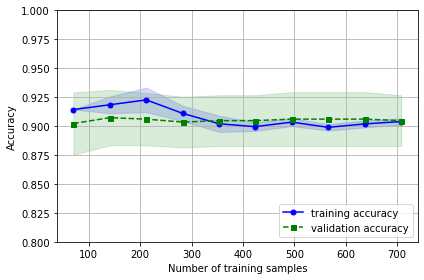

[[98  0]
 [23 76]]


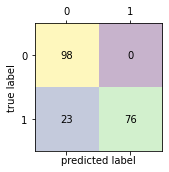

specificity: 0.7676767676767676
 precision: 0.8099173553719008
 recall: 1.0
 F1: 0.8949771689497716


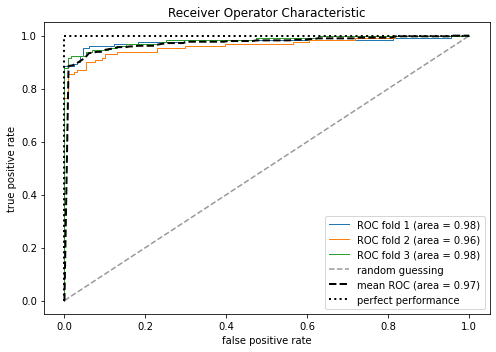

In [53]:
#LR
c_LR=best_params_LR['logisticregression__C']
penalty=best_params_LR['logisticregression__penalty']
solver=best_params_LR['logisticregression__solver']
Validation("LR",LogisticRegression(penalty=penalty, random_state=0, C=c_LR,solver=solver),X_train, y_train, X_test, y_test)

Test Accuracy: 0.883

CV accuracy: 0.903 +/- 0.022
CV accuracy scores: [0.89873418 0.91139241 0.94936709 0.88607595 0.87341772 0.89873418
 0.87341772 0.91025641 0.92307692 0.91025641]
CV accuracy: 0.903 +/- 0.022


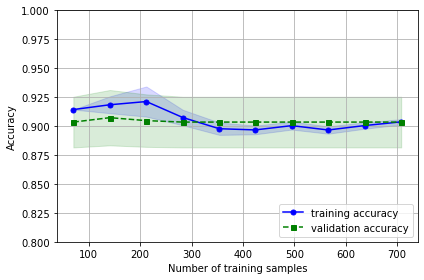

[[98  0]
 [23 76]]


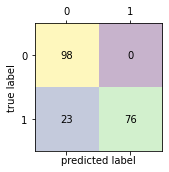

specificity: 0.7676767676767676
 precision: 0.8099173553719008
 recall: 1.0
 F1: 0.8949771689497716


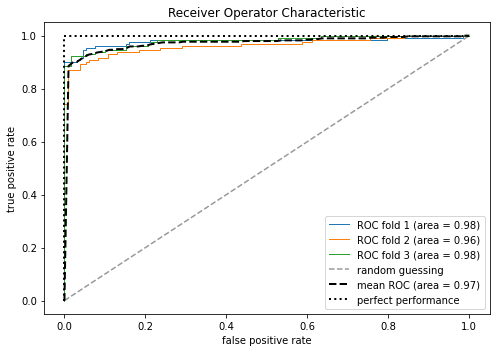

In [54]:
#SVM
# print(best_params_SVM)
c_SVC=best_params_SVM['svc__C']
gamma=best_params_SVM['svc__gamma']
kernel=best_params_SVM['svc__kernel']
Validation("SVM",SVC(C=c_SVC,gamma=gamma,kernel=kernel,probability=True),X_train, y_train, X_test, y_test)

note that random forest classifier is overfitting

Test Accuracy: 0.853

CV accuracy: 0.848 +/- 0.035
CV accuracy scores: [0.82278481 0.81012658 0.86075949 0.87341772 0.7721519  0.84810127
 0.79746835 0.85897436 0.91025641 0.91025641]
CV accuracy: 0.846 +/- 0.044


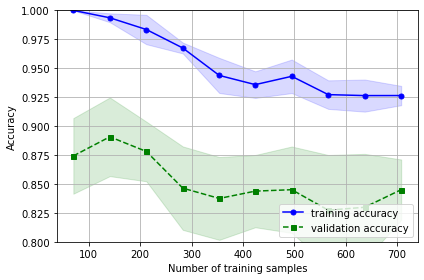

[[81 17]
 [12 87]]


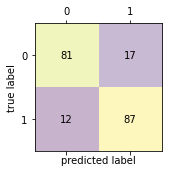

specificity: 0.8787878787878788
 precision: 0.8709677419354839
 recall: 0.826530612244898
 F1: 0.8481675392670157


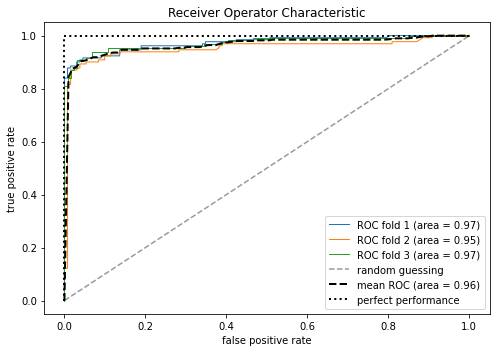

In [55]:

#RF
class_weight=best_params_RF['randomforestclassifier__class_weight']
max_depth=best_params_RF['randomforestclassifier__max_depth']
n_estimators=best_params_RF['randomforestclassifier__n_estimators']
Validation("RF",RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,class_weight=class_weight),X_train, y_train, X_test, y_test)

we would decide to pick LR because it has a CV accuracy of 0.905 with a standard deviation of +/- 0.022

# Final Measure of Performance

In [30]:
df_credit = df_credit.assign(Time=sc.fit_transform(df_credit['Time'].values.reshape(-1, 1)),
                             Amount=sc.fit_transform(df_credit['Amount'].values.reshape(-1, 1)))

X, y = df_credit.iloc[:, :-1].values, df_credit.iloc[:, -1].values

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1, stratify = y)

X_train_std = sc.fit_transform(X_train_orig)
X_test_std = sc.transform(X_test_orig)

Test Accuracy: 0.998

CV accuracy: 0.998 +/- 0.000
CV accuracy scores: [0.99828835 0.99824446 0.99824446 0.99824446 0.99824446 0.99828827
 0.99828827 0.99828827 0.99828827 0.99828827]
CV accuracy: 0.998 +/- 0.000


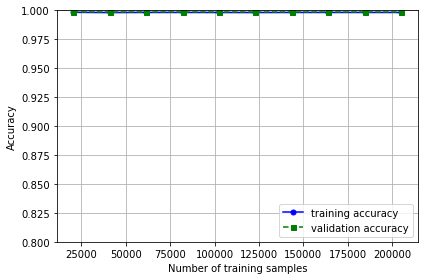

In [31]:
learningCurve("LR_final", LogisticRegression(penalty=penalty, random_state=0, C=c_LR,solver=solver),X_train_std, y_train_orig, X_test_std, y_test_orig)

[[56859     5]
 [   43    55]]


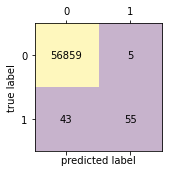

specificity: 0.5612244897959183
 precision: 0.9992443147868265
 recall: 0.9999120709060214
 F1: 0.9995780813248246


(0.5612244897959183,
 0.9992443147868265,
 0.9999120709060214,
 0.9995780813248246)

In [32]:
confusionMatrix("LR_final", LogisticRegression(penalty=penalty, random_state=0, C=c_LR,solver=solver),X_train_std, y_train_orig, X_test_std, y_test_orig)

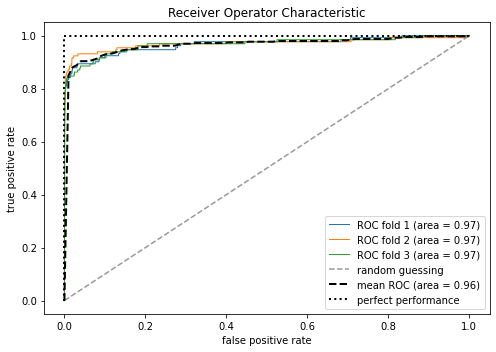

In [33]:
ROCCurve("LR_final", LogisticRegression(penalty=penalty, random_state=0, C=c_LR,solver=solver),X_train_std, y_train_orig, X_test_std, y_test_orig)